In [1]:
import pandas as pd
import numpy as np
from numpy import inf
import matplotlib.pyplot as plt
import seaborn as sns
%load_ext autoreload
%autoreload 2

from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, precision_recall_curve


from xgboost import XGBClassifier

import itertools
import random

pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

import practice_code as pc
import individual_stats as ind

from sklearn.model_selection import train_test_split, GridSearchCV

import warnings
warnings.filterwarnings('ignore')

In [2]:
clutch_time = pd.read_csv('CSV Files/clutch_time.csv')

In [3]:
clutch_time = pc.replace_nan(clutch_time)
clutch_time['total_blocks'] = (clutch_time['block'] != '')*1
clutch_time['assist_count'] = (clutch_time['assist'] != '')*1

In [4]:
reg = pd.read_csv('CSV Files/data_for_ids.csv')

In [5]:
ids = ind.add_ids(reg)

# Train_target (2015-2016 season)

In [6]:
train_target= clutch_time[clutch_time['data_set'] == '2015-2016 Regular Season']

In [11]:
stats_train_target = ind.object_to_int(train_target, 'points')
assists = ind.assist_stats(stats_train_target)
blks = ind.blk_stats(stats_train_target)
names = ind.player_names(stats_train_target)
train_target_stats = ind.merge_all(names, blks, assists, stats_train_target)
train_target_stats = ind.get_per_game_stats(train_target_stats)
train_target_stats = ind.merge_ids(train_target_stats, ids)

ValueError: labels ['points'] not contained in axis

In [ ]:
train_target_stats = ind.add_league_avg(train_target_stats)


# Train data (2004-2015)

In [13]:
train_clutch = clutch_time[clutch_time['data_set'] != '2015-2016 Regular Season']

In [14]:
train_clutch_time = pc.replace_nan(train_clutch)
train_clutch_time['total_blocks'] = (train_clutch_time['block'] != '')*1
train_clutch_time['assist_count'] = (train_clutch_time['assist'] != '')*1

In [15]:
player_stats_clutch = ind.object_to_int(train_clutch_time, 'points')
assists = ind.assist_stats(player_stats_clutch)
blks = ind.blk_stats(player_stats_clutch)
names = ind.player_names(player_stats_clutch)
train_clutch_stats = ind.merge_all(names, blks, assists, player_stats_clutch)
train_clutch_stats = ind.get_per_game_stats(train_clutch_stats)
train_clutch_stats = ind.merge_ids(train_clutch_stats, ids)

In [16]:
train_clutch_stats = ind.add_league_avg(train_clutch_stats)


# Test target (clutch or not in 2016-2017 season)

In [17]:
test_target = pd.read_csv('Test_data/first_test.csv')

In [18]:
test_target = test_target.drop('id', axis =1)
test_target = ind.merge_ids(test_target, ids)
test_target = ind.add_league_avg(test_target)

# X_test data

In [19]:
test_clutch_time = pc.replace_nan(clutch_time)
test_clutch_time['total_blocks'] = (test_clutch_time['block'] != '')*1
test_clutch_time['assist_count'] = (test_clutch_time['assist'] != '')*1

In [20]:
player_stats_test = ind.object_to_int(test_clutch_time, 'points')
assists = ind.assist_stats(player_stats_test)
blks = ind.blk_stats(player_stats_test)
names = ind.player_names(player_stats_test)
test_clutch_stats = ind.merge_all(names, blks, assists, player_stats_test)
test_clutch_stats = ind.get_per_game_stats(test_clutch_stats)
test_clutch_stats = ind.merge_ids(test_clutch_stats, ids)

In [21]:
test_clutch_stats = ind.add_league_avg(test_clutch_stats)

# import csv files for turnovers and ejections

### Keep al the ejections from total game sbecause if they are ejected they cant comebacck

In [22]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [23]:
turnover_data = turnover_data[turnover_data['data_set']!= '2015-2016 Regular Season']

In [24]:
turnover_data['pts_difference'] = turnover_data['away_score'] - turnover_data['home_score']

In [25]:
turnover_data = pc.clutch_moment(turnover_data)

In [26]:
x = turnover_data.groupby('player').count()
turnover_data = x[['event_type']]
turnover_data.reset_index(level=0, inplace=True)
turnover_data = turnover_data.rename(columns={'event_type':'total_turnovers'})

# merge these to train data

In [27]:
train_clutch_stats = pd.merge(train_clutch_stats,turnover_data,on='player', how = 'left')
                              
#ejection_data,on='player', how = 'left')


In [28]:
train_clutch_stats = train_clutch_stats.fillna(0)

In [29]:
train_clutch_stats['TPG'] = round(train_clutch_stats['total_turnovers'] / train_clutch_stats['total_games'],2)

In [45]:
#train_clutch_stats['league_TO_avg'] = round(train_clutch_stats['total_turnovers'].sum() / train_clutch_stats['total_games'].sum(),2)

# get TO and ejection data for train target

In [30]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [31]:
#target_ejection_data = ejection_data[ejection_data['data_set'] == '2015-2016 Regular Season']
target_turnover_data = turnover_data[turnover_data['data_set'] == '2015-2016 Regular Season']

In [32]:
target_turnover_data['pts_difference'] = target_turnover_data['away_score'] - target_turnover_data['home_score']

In [33]:
target_turnover_data = pc.clutch_moment(target_turnover_data)

In [34]:
x = target_turnover_data.groupby('player').count()
target_turnover_data = x[['event_type']]
target_turnover_data.reset_index(level=0, inplace=True)
target_turnover = target_turnover_data.rename(columns={'event_type':'total_turnovers'})

In [35]:
train_target_stats = pd.merge(train_target_stats,target_turnover,on='player', how = 'left')
train_target_stats = train_target_stats.fillna(0)
train_target_stats['TPG'] = round(train_target_stats['total_turnovers'] / train_target_stats['total_games'],2)
#train_target_stats['league_TO_avg'] = round(train_target_stats['total_turnovers'].sum() / train_target_stats['total_games'].sum(),2)
#train_target_stats['clutch_TO'] = train_target_stats['TPG'] < train_target_stats['league_TO_avg']
#target_clutch_stats['clutch_ejections'] = target_clutch_stats['ejections'] < target_clutch_stats['ejections/career']


# Do the same for x_test aka clutch time

In [36]:
turnover_data = pd.read_csv('CSV Files/reg_turnovers.csv')

In [37]:
turnover_data['pts_difference'] = turnover_data['away_score'] - turnover_data['home_score']
turnover_data = pc.clutch_moment(turnover_data)

In [38]:
x = turnover_data.groupby('player').count()
turnover_data = x[['event_type']]
turnover_data.reset_index(level=0, inplace=True)
turnover_data = turnover_data.rename(columns={'event_type':'total_turnovers'})

In [39]:
test_clutch_stats = pd.merge(test_clutch_stats,turnover_data,on='player', how = 'left')
test_clutch_stats = test_clutch_stats.fillna(0)
test_clutch_stats['TPG'] = round(test_clutch_stats['total_turnovers'] / test_clutch_stats['total_games'],2)
#test_clutch_stats['league_TO_avg'] = round(test_clutch_stats['total_turnovers'].sum() / test_clutch_stats['total_games'].sum(),2)
#test_clutch_stats['clutch_TO'] = test_clutch_stats['TPG'] < test_clutch_stats['league_TO_avg']


# And for the test target

In [91]:
test_target = pd.read_csv('Every_Season_Data/[2016-2017]-combined-stats.csv')
turnovers = test_target[test_target['event_type'].str.contains('urnover')]
turnovers['pts_difference'] = turnovers['away_score'] - turnovers['home_score']
turnovers = pc.clutch_moment(turnovers)
x = turnovers.groupby('player').count()
turnovers = x[['event_type']]
turnovers.reset_index(level=0, inplace=True)
turnovers = turnovers.rename(columns={'event_type':'total_turnovers'})

In [44]:
test_target = pd.read_csv('Every_Season_Data/[2016-2017]-combined-stats.csv')

In [45]:
test_target =  pc.add_columns(test_target)

In [46]:
col_to_remove = ['a1', 'a2', 'a3','a4','a5','h1','h2','h3','h4','h5', 'play_length', 'entered', 'left', 'possession', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'num', 'away', 'home', 'outof', 'opponent', 'reason', 'elapsed', 'play_id']

In [47]:
test_target = pc.replace_nan(test_target)
test_target = pc.remove_col(test_target, col_to_remove)
test_target = pc.remove_junk_rows(test_target, 'event_type')
regu, poffs = pc.regular_or_playoffs(test_target, 'data_set')

In [48]:
clutch = pc.clutch_moment(regu)
clutch = pc.remove_not_imp_games(clutch, 'game_id')

In [49]:
clutch = ind.object_to_int(clutch, 'points')
ast = ind.assist_stats(clutch)
blk = ind.blk_stats(clutch)
nme = ind.player_names(clutch)
clutch = ind.merge_all(nme, blk, ast, clutch)

In [50]:
test_target = ind.get_per_game_stats(clutch)
test_target = ind.merge_ids(test_target, ids)

In [51]:
test_target = ind.add_league_avg(test_target)


In [52]:
target = pd.merge(test_target,trunovers,on='player', how = 'left')
target = target.fillna(0)
target['TPG'] = round(target['total_turnovers'] / target['total_games'],2)
#target['league_TO_avg'] = round(target['total_turnovers'].sum() / target['total_games'].sum(),2)
#target['ejections'] = test_clutch_stats['ejections'].astype(np.int64)
#target['ejections/career']=round((test_clutch_stats['ejections'].sum() / test_clutch_stats['player'].count()), 2)
#target['clutch_TO'] = target['TPG'] < target['league_TO_avg']
#target['clutch_ejections'] = test_clutch_stats['ejections'] < test_clutch_stats['ejections/career']


In [53]:
train_target_stats = ind.add_scores(train_target_stats)
target = ind.add_scores(target)
train_clutch_stats = ind.add_scores(train_clutch_stats)
test_clutch_stats = ind.add_scores(test_clutch_stats)

In [54]:
train_target_stats = ind.is_clutch(train_target_stats)
target = ind.is_clutch(target)
train_clutch_stats = ind.is_clutch(train_clutch_stats)
test_clutch_stats = ind.is_clutch(test_clutch_stats)

# making sure that i have same players in y_train and x_train

In [53]:
players = train_target_stats[['player']]
train_clutch_stats = train_clutch_stats.merge(players, on='player')


In [54]:
# making sure that i have same players in y_train and x_train
x = train_clutch_stats[['player']]
train_target_stats = train_target_stats.merge(x, on='player')

# gotta get the same players in x_test and y_test

In [55]:
d = target[['player']]
test_clutch_stats = test_clutch_stats.merge(d, on='player')

In [56]:
#gotta get the same players in x_test and y_test
y = test_clutch_stats[['player']]
target = target.merge(y, on='player')

In [75]:
x_train.head()

,total_games,shots_made,shots_missed,3pt,3pt_shots,Dunk/Layup,Dunk/Layup_attempts,2pt_med/hard,med/hard_attempts,2fg_attempts,FT_made,FT_missed,assist_count,off_rebound,total_rebound,total_blocks,2pt_fg_made,total_shots,shooting%,FT%,APG,BPG,ORPG,RPG,easy_shot%,2pt%,3pt%,med/hard_fg%,league_all_shot_avg,league_2pt_avg,league_3pt_avg,league_hard2pt_avg,league_easy2pt_avg,league_ft%,total_turnovers,TPG,3pt_score,Hard_2Score,Easy_2Score,FT_score,total_score,clutch_score,is_clutch
0,102,56,110,17,66,20,55,19,45,100,91,20,30,8,35,2,39,166,33.7,82.0,0.29,0.02,0.08,0.34,36.4,39.0,25.8,42.2,40.2,44.7,30.3,35.4,59.8,76.2,27.0,0.26,0.643939,0.633333,0.363636,0.819820,2.200729,0.550182,1
1,4,2,0,0,0,1,1,1,1,2,1,0,2,1,6,2,2,2,100.0,100.0,0.50,0.50,0.25,1.50,100.0,100.0,0.0,100.0,40.2,44.7,30.3,35.4,59.8,76.2,0.0,0.00,0.000000,1.500000,1.000000,1.000000,3.500000,0.875000,0
2,128,68,62,0,3,33,50,35,77,127,71,32,22,41,162,23,68,130,52.3,68.9,0.17,0.18,0.32,1.27,66.0,53.5,0.0,45.5,40.2,44.7,30.3,35.4,59.8,76.2,17.0,0.13,0.000000,0.681818,0.660000,0.689320,1.901139,0.475285,0
3,198,176,190,3,9,61,80,112,277,357,79,38,23,78,240,38,173,366,48.1,67.5,0.12,0.19,0.39,1.21,76.2,48.5,33.3,40.4,40.2,44.7,30.3,35.4,59.8,76.2,21.0,0.11,0.833333,0.606498,0.762500,0.675214,2.767545,0.691886,1
4,39,10,20,3,10,5,9,2,11,20,11,7,4,8,36,2,7,30,33.3,61.1,0.10,0.05,0.21,0.92,55.6,35.0,30.0,18.2,40.2,44.7,30.3,35.4,59.8,76.2,7.0,0.18,0.750000,0.272727,0.555556,0.611111,2.009394,0.502348,0


In [77]:
x_train = train_clutch_stats.drop(['player_id','player', 'is_clutch', 'clutch_score', '2pt_fg_made', '3pt_score', 'med/hard_attempts', 'league_all_shot_avg',	'league_2pt_avg',	'league_3pt_avg',	'league_hard2pt_avg',	'league_easy2pt_avg',	'league_ft%'], axis = 1)
y_train = train_target_stats['is_clutch']


In [78]:
x_test = test_clutch_stats.drop(['player_id','player', 'is_clutch', 'clutch_score', '2pt_fg_made', '3pt_score', 'med/hard_attempts', 'league_all_shot_avg',	'league_2pt_avg',	'league_3pt_avg',	'league_hard2pt_avg',	'league_easy2pt_avg',	'league_ft%'], axis = 1)
y_test = target['is_clutch']

In [79]:
#model= GradientBoostingClassifier(learning_rate=0.28, max_depth=3, min_samples_leaf=100, n_estimators=100)
model= GradientBoostingClassifier()
fit = model.fit(x_train, y_train)
pred= fit.predict(x_test)


In [80]:
accuracy_score(y_test, pred)

0.9115384615384615

In [81]:
precision_score(y_test, pred)

0.0

In [82]:
recall_score(y_test, pred)

0.0

In [83]:
f1_score(y_test, pred)

0.0

In [209]:
parameters = {'learning_rate': [ 0.2, 0.25, .3], 'n_estimators': [10,100, 75, 50], 'max_depth': [2, 3, 5],
              'min_samples_leaf': [ 45 ,70, 60]}

In [210]:
gbc = GridSearchCV(GradientBoostingClassifier(), parameters, cv=5, scoring='accuracy')
gbc.fit(x_train, y_train)

GridSearchCV(cv=5, error_score='raise',
       estimator=GradientBoostingClassifier(criterion='friedman_mse', init=None,
              learning_rate=0.1, loss='deviance', max_depth=3,
              max_features=None, max_leaf_nodes=None,
              min_impurity_decrease=0.0, min_impurity_split=None,
              min_samples_leaf=1, min_samples_split=2,
              min_weight_fraction_leaf=0.0, n_estimators=100,
              presort='auto', random_state=None, subsample=1.0, verbose=0,
              warm_start=False),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'learning_rate': [0.2, 0.25, 0.3], 'n_estimators': [10, 100, 75, 50], 'max_depth': [2, 3, 5], 'min_samples_leaf': [45, 70, 60]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [211]:
gbc.best_params_

{'learning_rate': 0.2,
 'max_depth': 2,
 'min_samples_leaf': 70,
 'n_estimators': 10}

In [212]:
gbc.best_score_

0.8074324324324325

In [221]:
params={'max_depth': [4,5,3],'learning_rate': [0.14, 0.12,0.13], 'n_estimators': [30,20, 25], 'min_child_weight':[1,2,3]}

In [222]:
XGB = GridSearchCV(XGBClassifier(), params, cv= 10, scoring='accuracy')
XGB.fit(x_train, y_train)

GridSearchCV(cv=10, error_score='raise',
       estimator=XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'max_depth': [4, 5, 3], 'learning_rate': [0.14, 0.12, 0.13], 'n_estimators': [30, 20, 25], 'min_child_weight': [1, 2, 3]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='accuracy', verbose=0)

In [223]:
XGB.best_params_

{'learning_rate': 0.13,
 'max_depth': 4,
 'min_child_weight': 2,
 'n_estimators': 25}

In [224]:
XGB.best_score_

0.8243243243243243

In [84]:
#model = XGBClassifier(learning_rate=.13, max_depth=4, n_estimators=25, min_child_weight=2 )
model = XGBClassifier()
model.fit(x_train, y_train)
print(model)
y_pred=model.predict(x_test)
print("recall: %.2f%%" % recall_score(y_test, y_pred))
print("f1: %.2f%%" % f1_score(y_test, pred))
print("Accuracy: %.3f%%" % accuracy_score(y_test, y_pred))

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.1, max_delta_step=0,
       max_depth=3, min_child_weight=1, missing=None, n_estimators=100,
       n_jobs=1, nthread=None, objective='binary:logistic', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=1)
recall: 0.06%
f1: 0.00%
Accuracy: 0.912%


In [85]:
precision_score(y_test, y_pred)

0.1111111111111111

In [86]:
importances = model.feature_importances_

In [87]:
importances

array([0.02216749, 0.00738916, 0.0320197 , 0.01477833, 0.00738916,
       0.01724138, 0.01231527, 0.01970443, 0.00246305, 0.07389162,
       0.01724138, 0.04433497, 0.01970443, 0.00738916, 0.01477833,
       0.        , 0.04187192, 0.08374384, 0.06896552, 0.00492611,
       0.04187192, 0.13054188, 0.01231527, 0.0862069 , 0.02216749,
       0.04187192, 0.01724138, 0.06403941, 0.02216749, 0.        ,
       0.01477833, 0.03448276], dtype=float32)

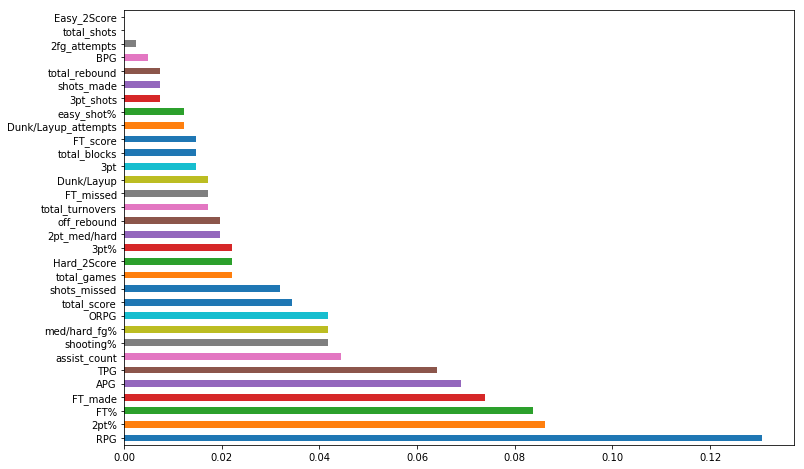

In [89]:
ig, axs = plt.subplots(1,0, figsize=(12,8))
(pd.Series(model.feature_importances_, index=x_test.columns)
   .nlargest(35)
   .plot(kind='barh'))

In [105]:
x = target[target['is_clutch']==1]

In [95]:
train_target_stats.is_clutch.value_counts()

0    281
1     15
Name: is_clutch, dtype: int64

In [119]:
y = train_target_stats[train_target_stats['is_clutch']==1]

In [142]:
test_clutch_stats.is_clutch.value_counts()

0    141
1    119
Name: is_clutch, dtype: int64

In [103]:
z =test_clutch_stats[test_clutch_stats['is_clutch']==1]

# Baseline model 
## Looks at all the shots and if your shooting% is above league avg yu are clutch 

In [57]:
target['clutch_all_shots'] = ((target['shooting%'] > target['league_all_shot_avg']) & (target['total_shots']>20))*1

test_clutch_stats['clutch_all_shots'] = ((test_clutch_stats['shooting%'] > test_clutch_stats['league_all_shot_avg']) & (test_clutch_stats['total_shots']>30))*1

train_clutch_stats['clutch_all_shots'] = ((train_clutch_stats['shooting%'] > train_clutch_stats['league_all_shot_avg']) & (train_clutch_stats['total_shots']>30))*1    
    
train_target_stats['clutch_all_shots'] = ((train_target_stats['shooting%'] > train_target_stats['league_all_shot_avg']) & (train_target_stats['total_shots']>20))*1

    
    

In [65]:
x_train = train_clutch_stats.drop(['player', 'player_id'],axis = 1)
y_train = train_target_stats['clutch_all_shots']
y_test = target['clutch_all_shots']
x_test = test_clutch_stats.drop(['player', 'player_id'],axis = 1)

In [66]:
model= GradientBoostingClassifier()
fit = model.fit(x_train, y_train)
pred= fit.predict(x_test)

In [67]:
recall_score(y_test, pred)

0.058823529411764705

In [68]:
f1_score(y_test, pred)

0.08888888888888888

In [71]:
accuracy_score(y_test, pred)

0.8423076923076923

In [72]:
precision_score(y_test, pred)

0.18181818181818182

In [ ]:
# x = ejects.groupby('player').count()
# ejects = x[['event_type']]
# ejects.reset_index(level=0, inplace=True)
# ejects = ejects.rename(columns={'event_type':'ejections'})

In [ ]:
# x = ejection_data.groupby('player').count()
# ejection_data = x[['event_type']]
# ejection_data.reset_index(level=0, inplace=True)
# ejection_data = ejection_data.rename(columns={'event_type':'ejections'})

In [ ]:
# d = []
# e = 0
# for value in x['total_shots']:
#     if value > 20:
#         y = 
#         d.append(value)
#     else:
#         d.append(e)
# x[''] = d



# d = []
# e = 0
# for value in x['3pt_shots']:
#     if value >= 10:
#         d.append(value)
#     else:
#         d.append(e)
# x['3pt_shots'] = d

In [ ]:
#ejection_data = pd.read_csv('CSV Files/reg_ejects.csv')
#ejection_data = ejection_data[ejection_data['data_set']!= '2015-2016 Regular Season']

In [ ]:
# train_clutch_stats['ejections'] = train_clutch_stats['ejections'].astype(np.int64)
# train_clutch_stats['ejections/career']=round((train_clutch_stats['ejections'].sum() / train_clutch_stats['player'].count()), 2)

In [ ]:
# new_id = []
# v = test_target['id'].max()
# for value in test_target['id']:
#     if value == 0:
#         v +=1
#         new_id.append(v)
#     else:
#         new_id.append(value)
# test_target['id'] = new_id

# Final test data

In [43]:
final_test = pd.read_csv('Every_Season_Data/[2017-2018]-combined-stats.csv', error_bad_lines=False)

b'Skipping line 34257: expected 44 fields, saw 46\nSkipping line 34258: expected 44 fields, saw 46\nSkipping line 34259: expected 44 fields, saw 46\nSkipping line 34260: expected 44 fields, saw 46\nSkipping line 34261: expected 44 fields, saw 46\nSkipping line 34262: expected 44 fields, saw 46\nSkipping line 34263: expected 44 fields, saw 46\nSkipping line 34264: expected 44 fields, saw 46\nSkipping line 34265: expected 44 fields, saw 46\nSkipping line 34266: expected 44 fields, saw 46\nSkipping line 34267: expected 44 fields, saw 46\nSkipping line 34268: expected 44 fields, saw 46\nSkipping line 34269: expected 44 fields, saw 46\nSkipping line 34270: expected 44 fields, saw 46\nSkipping line 34271: expected 44 fields, saw 46\nSkipping line 34272: expected 44 fields, saw 46\nSkipping line 34273: expected 44 fields, saw 46\nSkipping line 34274: expected 44 fields, saw 46\nSkipping line 34275: expected 44 fields, saw 46\nSkipping line 34276: expected 44 fields, saw 46\nSkipping line 3427

In [44]:
final_test = pc.add_columns(final_test)
final_test = pc.remove_junk_rows(final_test, 'event_type')
col_to_remove = ['a1', 'a2', 'a3','a4','a5','h1','h2','h3','h4','h5', 'play_length', 'entered', 'left', 'possession', 'shot_distance', 'original_x', 'original_y', 'converted_x', 'converted_y', 'num', 'away', 'home', 'outof', 'opponent', 'reason', 'elapsed', 'play_id']
final_test = pc.remove_col(final_test, col_to_remove)
final_test = pc.replace_nan(final_test)
final_regular_season, final_playoffs = pc.regular_or_playoffs(final_test, 'data_set')
final_clutch = pc.clutch_moment(final_regular_season)
final_clutch = pc.remove_not_imp_games(final_clutch, 'game_id')

In [45]:
final_clutch['total_blocks'] = (final_clutch['block'] != '')*1
final_clutch['assist_count'] = (final_clutch['assist'] != '')*1

In [96]:
#final_clutch['game_id'] = final_clutch['game_id'].astype('category')

In [30]:
#final_regular_season.date= pd.to_datetime(final_regular_season.date).dt.strftime('%d-%b-%y')

In [47]:
test_stats_clutch = ind.change_objects(final_clutch)

In [53]:
assists = ind.assist_stats(test_stats_clutch)
blks = ind.blk_stats(test_stats_clutch)
names = ind.player_names(test_stats_clutch)
names = ind.player_names(test_stats_clutch)
full_test_clutch_stats = ind.merge_all(names, blks, assists, test_stats_clutch)
full_test_clutch_stats = ind.get_per_game_stats(full_test_clutch_stats)
full_test_clutch_stats = ind.merge_ids(full_test_clutch_stats, ids)

In [54]:
full_test_clutch_stats = ind.add_league_avg(full_test_clutch_stats)

In [55]:
final_tos = pd.read_csv('Every_Season_Data/[2017-2018]-combined-stats.csv', error_bad_lines=False)
final_turnovers = final_tos[final_tos['event_type'].str.contains('urnover')]
final_turnovers['pts_difference'] = final_turnovers['away_score'] - final_turnovers['home_score']
final_turnovers = pc.clutch_moment(final_turnovers)
x = final_turnovers.groupby('player').count()
final_turnovers = x[['event_type']]
final_turnovers.reset_index(level=0, inplace=True)
final_turnovers = final_turnovers.rename(columns={'event_type':'total_turnovers'})

b'Skipping line 34257: expected 44 fields, saw 46\nSkipping line 34258: expected 44 fields, saw 46\nSkipping line 34259: expected 44 fields, saw 46\nSkipping line 34260: expected 44 fields, saw 46\nSkipping line 34261: expected 44 fields, saw 46\nSkipping line 34262: expected 44 fields, saw 46\nSkipping line 34263: expected 44 fields, saw 46\nSkipping line 34264: expected 44 fields, saw 46\nSkipping line 34265: expected 44 fields, saw 46\nSkipping line 34266: expected 44 fields, saw 46\nSkipping line 34267: expected 44 fields, saw 46\nSkipping line 34268: expected 44 fields, saw 46\nSkipping line 34269: expected 44 fields, saw 46\nSkipping line 34270: expected 44 fields, saw 46\nSkipping line 34271: expected 44 fields, saw 46\nSkipping line 34272: expected 44 fields, saw 46\nSkipping line 34273: expected 44 fields, saw 46\nSkipping line 34274: expected 44 fields, saw 46\nSkipping line 34275: expected 44 fields, saw 46\nSkipping line 34276: expected 44 fields, saw 46\nSkipping line 3427

In [56]:
full_test_clutch_stats = pd.merge(full_test_clutch_stats, final_turnovers, on='player', how = 'left')
full_test_clutch_stats = full_test_clutch_stats.fillna(0)
full_test_clutch_stats['TPG'] = round(full_test_clutch_stats['total_turnovers'] / full_test_clutch_stats['total_games'],2)

In [57]:
full_test_clutch_stats = ind.add_scores(full_test_clutch_stats)

full_test_clutch_stats = ind.is_clutch(full_test_clutch_stats)

In [59]:
full_test_clutch_stats.tail()

,player,player_id,total_games,shots_made,shots_missed,3pt,3pt_shots,Dunk/Layup,Dunk/Layup_attempts,2pt_med/hard,med/hard_attempts,2fg_attempts,FT_made,FT_missed,assist_count,off_rebound,total_rebound,total_blocks,2pt_fg_made,total_shots,shooting%,FT%,APG,BPG,ORPG,RPG,easy_shot%,2pt%,3pt%,med/hard_fg%,league_all_shot_avg,league_2pt_avg,league_3pt_avg,league_hard2pt_avg,league_easy2pt_avg,league_ft%,total_turnovers,TPG,3pt_score,Hard_2Score,Easy_2Score,FT_score,total_score,clutch_score,is_clutch
316,Torrey Craig,0,2,1,0,1,1,0,0,0,0,0,0,0,0,1,2,0,0,1,100.0,0.0,0.0,0.0,0.5,1.0,0.0,0.0,100.0,0.0,37.7,45.6,29.8,36.2,61.9,75.3,0.0,0.00,2.5,0.0,0.0,0.0,2.50,0.6250,0
317,Tyler Dorsey,0,6,0,2,0,1,0,1,0,0,1,2,0,0,0,3,0,0,2,0.0,100.0,0.0,0.0,0.0,0.5,0.0,0.0,0.0,0.0,37.7,45.6,29.8,36.2,61.9,75.3,1.0,0.17,0.0,0.0,0.0,1.0,0.83,0.2075,0
318,Tyrone Wallace,0,1,1,0,0,0,1,1,0,0,1,0,0,0,0,0,0,1,1,100.0,0.0,0.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,37.7,45.6,29.8,36.2,61.9,75.3,1.0,1.00,0.0,0.0,1.0,0.0,0.00,0.0000,0
319,Xavier Rathan-Mayes,0,1,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,37.7,45.6,29.8,36.2,61.9,75.3,0.0,0.00,0.0,0.0,0.0,0.0,0.00,0.0000,0
320,Zach Collins,0,1,1,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,1,100.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,100.0,0.0,37.7,45.6,29.8,36.2,61.9,75.3,1.0,1.00,2.5,0.0,0.0,0.0,1.50,0.3750,0
